# Course Project

### Guilherme Gil, Alva Ringi & Francisco Simões

## Dataset

You will examine the ProPublica COMPAS dataset, which consists of all criminal defendants who were subject to COMPAS screening in Broward County, Florida, during 2013 and 2014. For each defendant, various information fields (‘features’) were also gathered by ProPublica. Broadly, these fields are related to the defendant’s demographic information (e.g., gender and race), criminal history (e.g., the number of prior offenses) and administrative information about the case (e.g., the case number, arrest date, risk of recidivism predicted by the COMPAS tool). Finally, the dataset also contains information about whether the defendant did actually recidivate or not.

The COMPAS score uses answers to 137 questions to assign a risk score to defendants -- essentially a probability of re-arrest. The actual output is two-fold: a risk rating of 1-10 and a "low", "medium", or "high" risk label.

Link to dataset: https://github.com/propublica/compas-analysis

The file we will analyze is: compas-scores-two-years.csv

Link to the ProPublica article:

https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing


## Project goal

The project has three parts: 

1. The COMPAS scores have been shown to have biases against certain racial groups. Analyze the dataset to highlight these biases.  

2. Based on the features in the COMPAS dataset, train classifiers to predict who will re-offend (hint: no need to use all features, just the ones you find relevant).  Study if your classifiers are more or less fair than the COMPAS classifier. 

3. Build a fair classifier (last lecture will cover fair classification techniques). Is excluding the race from the feature set enough?


In [ ]:
# installations that might be needed to run this notebook

# !pip3 install cvxpy
# !pip3 install tensorflow
# !pip3 install seaborn
# !pip3 install sklearn

## Load the data

We first need to load the data from the ProPublica repo:
https://github.com/propublica/compas-analysis


In [3]:
import urllib
import os,sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import feature_extraction
from sklearn import preprocessing
from sklearn.metrics import accuracy_score,confusion_matrix

from random import seed, shuffle
#from __future__ import division
#from collections import defaultdict
#import utils as ut

SEED = 1234
seed(SEED)
np.random.seed(SEED)
pd.set_option('display.max_columns', None)
def check_data_file(fname):
    files = os.listdir(".") # get the current directory listing
    print("Looking for file '%s' in the current directory...",fname)

    if fname not in files:
        print("'%s' not found! Downloading from GitHub...",fname)
        addr = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
        response = urllib.request.urlopen(addr)
        data = response.read()
        fileOut = open(fname, "wb")
        fileOut.write(data)
        fileOut.close()
        print("'%s' download and saved locally..",fname)
    else:
        print("File found in current directory..")
    
COMPAS_INPUT_FILE = "compas-scores-two-years.csv"
check_data_file(COMPAS_INPUT_FILE)  

df = pd.read_csv(COMPAS_INPUT_FILE)

Looking for file '%s' in the current directory... compas-scores-two-years.csv
File found in current directory..


# Part 1: Analysis of the dataset and its biases

- **The dataset contains data on how many convicts?** 

In [ ]:
print("There are ", df.shape[0], "samples in the dataset.")

- **What are the features the dataset contains?**

In [ ]:
df.head()

- **Are there missing values (NaN)? are there outliers?** 

- **Does ProPublica mentions how to clean the data?** 

Yes, in the article "How We Analyzed the COMPAS Recidivism Algorithm" (https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm) ProPublica describes how they cleaned the data. One part of their cleaning was done through the function which is described below.

Furthermore the ProPublica article "Machine Bias Risk Assessments in Crinimal Sentencing"(https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing) discusses what features that should and should not be used for predicting recidivism. Brennan who represents Northpointe that is behind the COMPAS assessment sais that removing all featuers that are in someway correlated to race would give a very low accuracy. There will always be a tradeoff between fairness and accuracy. 

- **What is the effect of the following function?**

In [ ]:
print(df.shape)
df = df.dropna(subset=["days_b_screening_arrest"]) # dropping missing vals
df = df[
    (df.days_b_screening_arrest <= 30) &  
    (df.days_b_screening_arrest >= -30) &  
    (df.is_recid != -1) &
    (df.c_charge_degree != 'O') &
    (df.score_text != 'N/A')
]
df.reset_index(inplace=True, drop=True) # renumber the rows from 0 again

**Comment**: It first removes all rows in the dataset that have no value for the feature "days before screening arrest". The we drop rows where the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested because maybe they don't have the right offense. If there's no compas case, the column "is_recid" is marked as -1 so we can also drop these rows. Offenses with a charge degree of 'O' won't result in jail time so we will also not consider the rows with this value. Then we also drop the rows in which the column "score_text" has the value 'N/A'.

## Basic analysis of demographics

- **What are the different races present in the dataset?** 

In [ ]:
df["race"].unique().tolist()

- **What is the number of people by age category?**

In [ ]:
age_cat_names = list(df["age_cat"].unique().tolist())
age_cat_size = list(df.groupby(["age_cat"], sort=False).size())
plt.bar(age_cat_names, age_cat_size)
plt.title("Number of people per age category")
plt.show()

**Comment**: There is a majority of people in the dataset are between 25 and 45 years old.

- **What is the number of people by COMPAS score (decile_score)?**

In [ ]:
decile_score_names = list(df["decile_score"].unique().tolist())
decile_score_size = list(df.groupby("decile_score", sort=False).size())
plt.bar(decile_score_names, decile_score_size)
plt.title("Number of people per COMPAS score")
plt.show()

**Comment**: The by far most common score is 1. The higher score, the less common.

- **What is the number of people by COMPAS risk category (score_text)?**

In [ ]:
score_text_names = list(df["score_text"].unique().tolist())
score_text_size = list(df.groupby("score_text", sort=False).size())
plt.bar(score_text_names, score_text_size)
plt.title("Number of people per COMPAS risk category")
plt.show()

**Comment**: The by far most common class is "low score", followed by "medium" and "high". This follows well the distribution of the numerical scores observed in the plot above.

- **What is the number of people by race?**

In [ ]:
race_names = list(df["race"].unique().tolist())
race_size = list(df.groupby("race", sort=False).size())
plt.bar(race_names, race_size)
plt.xticks(rotation=20)
plt.title("Number of people per race")
plt.show()

**Comment**: There are very few Native American and Asian people in this dataset. We do not think there are enough people in these groups to have an unbiased estimator for them. For this reason, we will remove the categories "Native American" and "Asian" and place these samples in the category "Other".

In [ ]:
df.loc[(df.race == 'Asian'),'race']='Other'
df.loc[(df.race == 'Native American'),'race']='Other'

## Basic investigations of gender and race bias in COMPAS scores

- **What is the mean COMPAS score (decile_score) per race and gender?** 

In [ ]:
# mean score per race
race_names = list(df["race"].unique().tolist())
race_score_mean = list(df.groupby(["race"], sort=False).mean()["decile_score"])
plt.bar(race_names, race_score_mean)
plt.title("Mean COMPAS score per race")
plt.show()

# mean score per gender
sex_names = list(df["sex"].unique().tolist())
sex_score_mean = list(df.groupby(["sex"], sort=False).mean()["decile_score"])
plt.bar(sex_names, sex_score_mean)
plt.title("Mean COMPAS score per gender")
plt.show()

**Comment**: The mean score is the highest for the race group "African-American" which indicates that there is a bias against them. For men women, the mean score is similar which indicates that there are not much bias based on gender.

- **What is the distribution (histogram) of decile_score per race and gender?**

In [ ]:
# decile score per race
df.hist(column='decile_score', by=["race"],figsize = (9,7));
plt.show()

# decile score per gender
df.hist(column='decile_score', by=["sex"],figsize = (9,3));
plt.show()

**Comment**: There seems to be a bias towards African American people since the histogram distribution on this race is more evenly distributed when compared to the other races histograms (we can observe a higher percentage of higher scores in the African American race). For the other races we can see that the histogram is more squewed to lower values.

Comparing men and women, we see that the decile score distribution is similar for the two genders which indicates that there is not much bias against any of them.

- **How many people were re-arrested?** 

In [ ]:
rearrested = df[df["two_year_recid"]==1]
print("Number of Re-arrests:", len(rearrested.index))

- **Compute the recidivism (i.e., people that got re-arrested) rates by race and gender**

In [ ]:
# calculate number of re-arrested people as well as total number of people per race
races_names = list(df["race"].unique().tolist())
race_nr_ra = list(df.loc[(df['two_year_recid'] == 0)].groupby(["race"], sort=False).size())
race_nr = list(df.groupby(["race"], sort=False).size())

# calculate ratios per race
race_ra_rate = []
for i in range(len(races_names)):
    race_ra_rate.append(1-(race_nr_ra[i] / race_nr[i]))

# plot result
plt.bar(race_names, race_ra_rate)
plt.title("Recidivism rate per race")
plt.show()

# calculate number of re-arrested people as well as total number of people per gender
sex_names = list(df["sex"].unique().tolist())
sex_nr_ra = list(df.loc[(df['two_year_recid'] == 0)].groupby(["sex"], sort=False).size())
sex_nr = list(df.groupby(["sex"], sort=False).size())

# calculate ratios per gender
sex_ra_rate = []
for i in range(len(sex_names)):
    sex_ra_rate.append(1-(sex_nr_ra[i] / sex_nr[i]))

# plot result    
plt.bar(sex_names, sex_ra_rate)
plt.title("Recidivism rate per sex")
plt.show()

**Comment**: The recidivism rate is higher for African-Americans compared to the other races. This indicates that the dataset itself is bias. With a bias dataset, classifiers will learn these patterns and, in this case, give higher decile scores to African-Americans.

Comparing genders, the recidivism rate is higher for men than women. This is not as clearly reflected in the decile scores as in the case with race. The mean decile score for men and women is more equal than the recidivism rate in the dataset.

In [19]:
dfr = df[["decile_score","two_year_recid","sex","race"]]

def is_recid(row):
    if(row["decile_score"] >= 5):
        return 1
    else:
        return 0
    
dfr['pred_is_recid'] = dfr.apply (lambda row: is_recid(row), axis=1)
dfr.head()


/tmp/ipykernel_27624/368411507.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfr['pred_is_recid'] = dfr.apply (lambda row: is_recid(row), axis=1)


,decile_score,two_year_recid,sex,race,pred_is_recid
0,1,0,Male,Other,0
1,3,1,Male,African-American,0
2,4,1,Male,African-American,0
3,8,0,Male,African-American,1
4,1,0,Male,Other,0


**Comment**: We consider any decile scores equal or above 5 to be a positive recidivism prediction since the decile score goes from 1 to 10.

- **What is the accuracy of the COMPAS scores to predict recidivism**

In [ ]:
accuracy_score(dfr["two_year_recid"], dfr["pred_is_recid"])

- **Is the accuracy higher/lower if we look at particular races/genders?**

In [ ]:
races = df["race"].unique().tolist()
genders = ["Male","Female"]
for race in races:
    aux_df = dfr.loc[dfr['race'] == race]
    acc = accuracy_score(aux_df["two_year_recid"], aux_df["pred_is_recid"])
    print("Accuracy for {race} is {acc}".format(race = race, acc = acc))

for sex in genders:
    aux_df = dfr.loc[dfr['sex'] == sex]
    acc = accuracy_score(aux_df["two_year_recid"], aux_df["pred_is_recid"])
    print("Accuracy for {sex} is {acc}".format(sex = sex, acc = acc))

**Comment**: The accuracy seems to be lower for African-Americans than for any other race, which might indicate the existence of some bias. As for gender, both accuracies are extremely similar.

- **What about false positives and false negatives?**

In [17]:
def makeCM (dfr,label):
    cf_matrix = confusion_matrix(dfr["two_year_recid"], dfr["pred_is_recid"])

    group_names = ['True Neg','False Pos','False Neg','True Pos']

    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)

    ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

    ax.set_title('Confusion Matrix for ' + label);
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

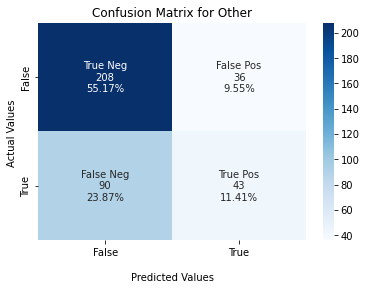

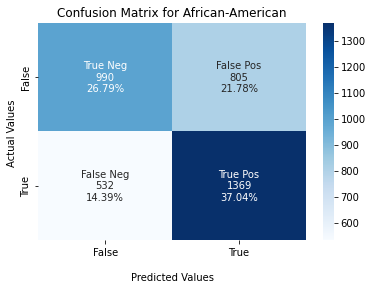

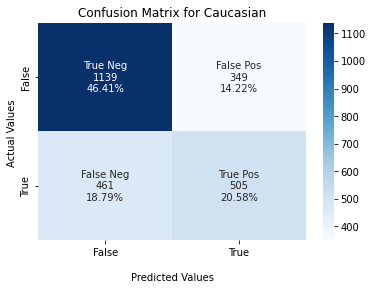

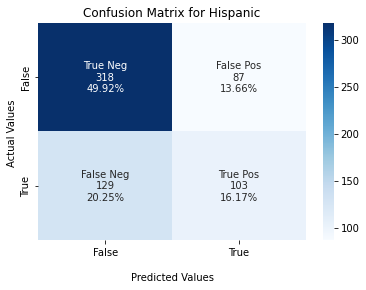

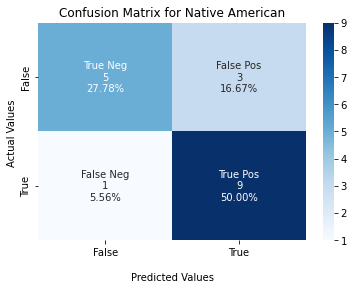

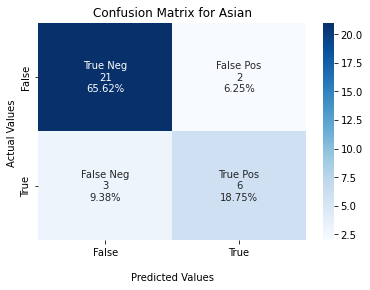

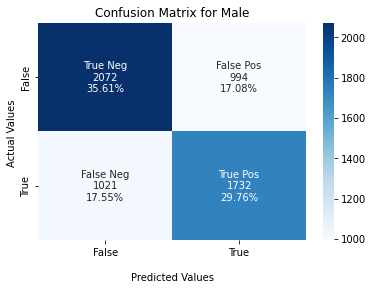

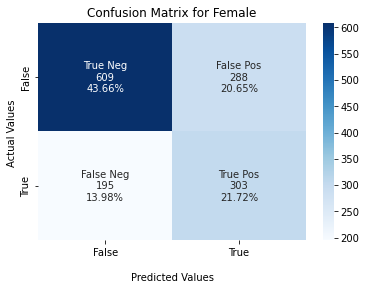

In [20]:
races = df["race"].unique().tolist()
genders = ["Male","Female"]
for race in races:
    aux_df = dfr.loc[dfr['race'] == race]
    makeCM(aux_df,race)  

for sex in genders:
    aux_df = dfr.loc[dfr['sex'] == sex]
    makeCM(aux_df,sex)

**Comment**: From the confusion matrices we can see that the false positive rate is highest among African-Americans indicating that there's a bias against them. The opposite can be found for the other races. The False Negatives is then lower for African-Americans than for other races meaning that the model does a bad job at identifying people that will recomit a crime if they are not African-American.

# Choosing Features

**Comment**: Below we choose what features to use when training our algorithms. We have chosen to use:
- **Sex**: Female, male
- **Age category**: (<25, 25-45, >45 years) 
- **Charge degree**: Misdemeanors, felony
- **Race**: African american, caucasian, hispanic and others (including asian and native american since we have too little data to analyze these races independently)
- **Priors count**: Number of earlier crimes
- **Juvenile mesdemeanor count**: Number of juvenile crimes, misdemeanors
- **Juvenile felony count**: Number of juvenile crimes, felonies
- **Juvenile other count**: Number of juvenile crimes, neither misdemanors nor felonies
- **Two years recid**: Ground truth

Features like e.g. names and dates are not being used since we do not consider them interesting for the prediction. 

We also make all features numerical (using the function "OneHotEncoder") since some algorithms for classifying can only handle numerical data. 

In [4]:
# choose features
dfa = df[["sex","age_cat","race","priors_count","two_year_recid","juv_misd_count","juv_fel_count","juv_other_count","c_charge_degree"]]

In [5]:
# merge race groups "asian" and "native american" with "other"
dfa.loc[(df.race == 'Asian'),'race']='Other'
dfa.loc[(df.race == 'Native American'),'race']='Other'

In [6]:
# make non-numerical features numerical
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
column_trans = make_column_transformer(
    (OneHotEncoder(), ['sex', 'age_cat',"c_charge_degree","race"]),
    remainder='passthrough')
d = column_trans.fit_transform(dfa)

In [7]:
# clean labels
labels = column_trans.get_feature_names_out()

def cleanLabels(label):
    if("onehotencoder__" in label):
        return label.removeprefix("onehotencoder__")
    else:
        return label.removeprefix("remainder__")
cleanedLabels = map(cleanLabels,labels)
listedLabels = list(map(cleanLabels,labels))

In [8]:
# create new dataframe with only numerical data
df_cleaned = pd.DataFrame(data=d,columns=cleanedLabels)

In [9]:
from sklearn.preprocessing import StandardScaler
labels = ["priors_count","juv_misd_count","juv_fel_count","juv_other_count"]
to_scale = df_cleaned[labels]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(to_scale)
df_scaled =  pd.DataFrame(data=scaled_data,columns = labels)
df_cleaned.drop(columns = labels)
dfa_num = pd.concat([df_cleaned,df_scaled], axis=1)
dfa_num

,sex_Female,sex_Male,age_cat_25 - 45,age_cat_Greater than 45,age_cat_Less than 25,c_charge_degree_F,c_charge_degree_M,race_African-American,race_Caucasian,race_Hispanic,race_Other,priors_count,two_year_recid,juv_misd_count,juv_fel_count,juv_other_count,priors_count,juv_misd_count,juv_fel_count,juv_other_count
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.711240,-0.187414,-0.141855,-0.218065
1,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.711240,-0.187414,-0.141855,-0.218065
2,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,1.0,0.108063,-0.187414,-0.141855,1.775750
3,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.506414,1.873571,-0.141855,-0.218065
4,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,-0.301588,-0.187414,-0.141855,-0.218065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.711240,-0.187414,-0.141855,-0.218065
7210,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.711240,-0.187414,-0.141855,-0.218065
7211,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.711240,-0.187414,-0.141855,-0.218065
7212,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,-0.096763,-0.187414,-0.141855,-0.218065


# Part 2: Train Classifiers

**Comment**: Below we randomly split our data into a training set (70% of the dataset) and a test set (30% of the dataset). 

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score
from sklego.metrics import p_percent_score
from sklego.metrics import equal_opportunity_score
Y = dfa_num["two_year_recid"]
X = dfa_num.drop(columns="two_year_recid")

X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.30, random_state=42)

In [11]:
def DisplayCM (cf_matrix, label):  
    group_names = ['True Neg','False Pos','False Neg','True Pos']

    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)

    ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

    ax.set_title('Confusion Matrix for ' + label);
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

In [12]:
def SetupMatrix(cf, normalize):
    predictions = cf.predict(X_test)
    if normalize:
        for p in predictions:
            if p[0]>=0.5:
                p[0] = 1
            else:
                p[0] = 0 
    cm_data = X_test.copy() # do we change X_test by doing this? If so, we can't do this
    cm_data["two_year_recid"] = y_test
    cm_data["predictions"] = predictions # add the predictions to the table with data
    
    
    races = ["race_African-American","race_Caucasian","race_Hispanic","race_Other"]
   # genders = ["sex_Male","sex_Female"]

    for race in races:
        cm_data_filtered = cm_data.loc[cm_data[race] == 1.0]
        cm = confusion_matrix(cm_data_filtered["two_year_recid"], cm_data_filtered["predictions"])
        DisplayCM(cm, race)

  #  for sex in genders:
   #     cm_data_filtered = cm_data.loc[cm_data[sex] == 1.0]
   #     cm = confusion_matrix(cm_data_filtered["two_year_recid"], cm_data_filtered["predictions"])
    #    DisplayCM(cm, sex)

## Logistic Regression

In [13]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
clf.predict(X_test)
clf.score(X_test,y_test)
#cross validation for reg

0.6877598152424942

In [14]:
scores = []
for c in np.arange (0.01, 1, 0.05):
    clf = LogisticRegression(random_state=0,C = c)
    cv = cross_validate(clf, X_train, y_train, cv=10,scoring='f1_macro')
    score = np.mean(cv["test_score"])
    scores.append([score,c])
reg = max(scores)
print(reg)

[0.6461335733360996, 0.9600000000000001]


In [15]:
clf = LogisticRegression(random_state=0,C = reg[1] ).fit(X_train, y_train)
clf.predict(X_test)
clf.score(X_test,y_test)

0.6877598152424942

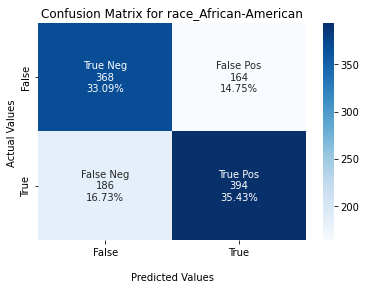

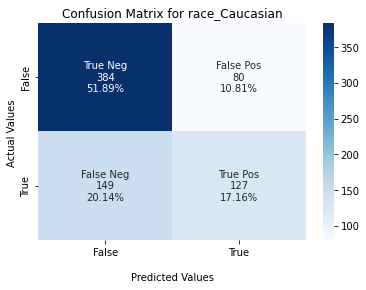

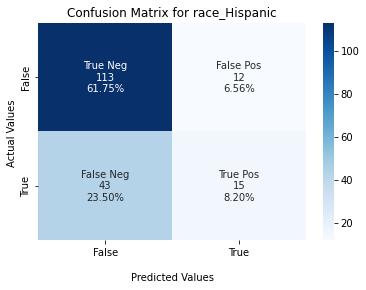

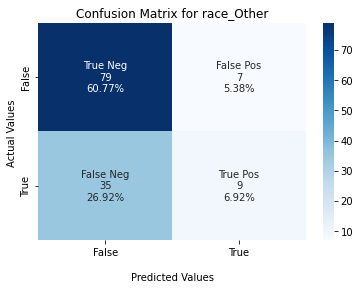

In [16]:
# confusion matrices for logistic regression
SetupMatrix(clf,0)

**Comment**: Our Logistic Regression model has a higher False Positive rate for African-Americans when compared to the other races. However, it's an improvement from the COMPAS predictor since our False Positive rate is lower by more than 7% (at the cost of -2% for the True Positive rate). Yet, it's still higher than the other races' rates. In fact, the other races present a fairly high False Negative rate, meaning a lot of people predicted to not re-commit crimes will actually do so. Our False Negative rates are worse than the COMPAS' ones.

In [ ]:
print("P% score for African-American feature: " + str(p_percent_score(sensitive_column="race_African-American")(clf, X)))
print("P% score for Caucasian feature: " + str(p_percent_score(sensitive_column="race_Caucasian")(clf, X)))
print("P% score for Hispanic feature: " + str(p_percent_score(sensitive_column="race_Hispanic")(clf, X)))
print("P% score for Other Race feature: " + str(p_percent_score(sensitive_column="race_Other")(clf, X)))

In [ ]:
print("Equal opportunity score for African-American feature: " + str(equal_opportunity_score(sensitive_column="race_African-American")(clf, X,Y)))
print("Equal opportunity score for Caucasian feature: " + str(equal_opportunity_score(sensitive_column="race_Caucasian")(clf, X,Y)))
print("Equal opportunity score for Hispanic feature: " + str(equal_opportunity_score(sensitive_column="race_Hispanic")(clf, X,Y)))
print("Equal opportunity score for Other Race feature: " + str(equal_opportunity_score(sensitive_column="race_Other")(clf, X,Y)))

In [ ]:
importance = clf.coef_[0]
# summarize feature importance
j = 0
for i,v in enumerate(importance):
    print('Feature: %0s, Score: %.5f' % (listedLabels[j],v))
    j += 1
# plot feature importance
print(len(listedLabels))
print(len(importance))
plt.figure(figsize=(10, 5), dpi=80)
plt.bar(listedLabels[:-1], importance)
plt.rcParams['font.size'] = '25'
plt.xticks(rotation=90)
plt.show()

**Comment**: The most important feature for predicting recidivism is age. An age under 25 increases the risk of being predicted as high risk. An age over 45 lowers the risk of being predicted high risk. The second most importent features are related to earlier commited crimes. Considering race, african americans and caucasians are more likely to be predicted as high risk than hispanics and others.

## SVC

In [ ]:
from sklearn.svm import SVC
svc = make_pipeline(StandardScaler(), SVC(gamma='auto'))
svc.fit(X_train, y_train)
svc.score(X_test,y_test)
pred = svc.predict(X_test)
print( "Accuracy " + str(svc.score(X_test,y_test)))
f1 = f1_score(y_test, pred, average='macro')
print("F1-Score " + str(f1))

In [ ]:
scores = []
for c in np.arange (0.01, 1, 0.05):
    svc = make_pipeline(StandardScaler(), SVC(gamma='auto', C = c))
    cv = cross_validate(svc, X_train, y_train, cv=10)
    score = np.mean(cv["test_score"])
    scores.append([score,c])
reg = max(scores)
print(reg)

In [ ]:
best_svc = make_pipeline(StandardScaler(), SVC(gamma='auto',C = reg[1]))
best_svc.fit(X_train, y_train)
pred = best_svc.predict(X_test)
print( "Accuracy " + str(best_svc.score(X_test,y_test)))
f1 = f1_score(y_test, pred, average='macro')
print("F1-Score " + str(f1))

In [ ]:
# confusion matrices for SVC
SetupMatrix(best_svc,0)

**Comment**: Just like for the Logistic Regression, we're able to improve the False Positive rate for the African-Americans, yet this value is still higher when compared to the other races. And we can draw the same conclusion regarding the False Negative rates being too high, higher than the COMPAS' rates.

In [ ]:
print("P% score for African-American feature: " + str(p_percent_score(sensitive_column="race_African-American")(best_svc, X)))
print("P% score for Caucasian feature: " + str(p_percent_score(sensitive_column="race_Caucasian")(best_svc, X)))
print("P% score for Hispanic feature: " + str(p_percent_score(sensitive_column="race_Hispanic")(best_svc, X)))
print("P% score for Other Race feature: " + str(p_percent_score(sensitive_column="race_Other")(best_svc, X)))

In [ ]:
print("Equal opportunity score for African-American feature: " + str(equal_opportunity_score(sensitive_column="race_African-American")(best_svc, X,Y)))
print("Equal opportunity score for Caucasian feature: " + str(equal_opportunity_score(sensitive_column="race_Caucasian")(best_svc, X,Y)))
print("Equal opportunity score for Hispanic feature: " + str(equal_opportunity_score(sensitive_column="race_Hispanic")(best_svc, X,Y)))
print("Equal opportunity score for Other Race feature: " + str(equal_opportunity_score(sensitive_column="race_Other")(best_svc, X,Y)))

## Nearest Neighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
k_scores = []
for k in range(3,12,2):
    neigh = KNeighborsClassifier(n_neighbors=k)
    cv = cross_validate(neigh, X_train, y_train, cv=5)
    k_score = np.mean(cv["test_score"])
    k_scores.append([k_score,k])
k_reg = max(k_scores)
print(k_reg)

In [ ]:
best_neigh = KNeighborsClassifier(n_neighbors=k_reg[1])
best_neigh.fit(X_train, y_train)
pred = best_neigh.predict(X_test)
print( "Accuracy " + str(best_neigh.score(X_test,y_test)))
f1 = f1_score(y_test, pred, average='macro')
print("F1-Score " + str(f1))

In [ ]:
# confusion matrices for Nearest Neighbors
SetupMatrix(best_neigh,0)

**Comment**: We seem to have an improvement on this classifier regarding the False Positive rates. These have a much smaller variation between races, meaning we're heading torwards a fairer model. We're also able to drop the False Negative rates slightly compared to the previous classifiers, edging closer to the COMPAS' rates.

In [ ]:
print("P% score for African-American feature: " + str(p_percent_score(sensitive_column="race_African-American")(best_neigh, X)))
print("P% score for Caucasian feature: " + str(p_percent_score(sensitive_column="race_Caucasian")(best_neigh, X)))
print("P% score for Hispanic feature: " + str(p_percent_score(sensitive_column="race_Hispanic")(best_neigh, X)))
print("P% score for Other Race feature: " + str(p_percent_score(sensitive_column="race_Other")(best_neigh, X)))

In [ ]:
print("Equal opportunity score for African-American feature: " + str(equal_opportunity_score(sensitive_column="race_African-American")(best_neigh, X,Y)))
print("Equal opportunity score for Caucasian feature: " + str(equal_opportunity_score(sensitive_column="race_Caucasian")(best_neigh, X,Y)))
print("Equal opportunity score for Hispanic feature: " + str(equal_opportunity_score(sensitive_column="race_Hispanic")(best_neigh, X,Y)))
print("Equal opportunity score for Other Race feature: " + str(equal_opportunity_score(sensitive_column="race_Other")(best_neigh, X,Y)))

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
##code from https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)


In [ ]:
best_rf = RandomForestClassifier(max_depth=rf_random.best_params_["max_depth"], random_state=0, n_estimators=rf_random.best_params_["n_estimators"],min_samples_split=rf_random.best_params_["min_samples_split"],min_samples_leaf=rf_random.best_params_["min_samples_leaf"],max_features=rf_random.best_params_["max_features"],bootstrap=rf_random.best_params_["bootstrap"])
best_rf.fit(X_train, y_train)
pred = best_rf.predict(X_test)
print( "Accuracy " + str(best_rf.score(X_test,y_test)))
f1 = f1_score(y_test, pred, average='macro')
print("F1-Score " + str(f1))

In [ ]:
# confusion matrices for Random Forest
SetupMatrix(best_rf,0)

**Comment**: With this model, we achieve our lowest False Positive rate for African-Americans while maintaining a slightly lower rate for the other races. The False Negative rates are still within the expected values (similar to Nearest Neighbors).

In [ ]:
print("P% score for African-American feature: " + str(p_percent_score(sensitive_column="race_African-American")(best_rf, X)))
print("P% score for Caucasian feature: " + str(p_percent_score(sensitive_column="race_Caucasian")(best_rf, X)))
print("P% score for Hispanic feature: " + str(p_percent_score(sensitive_column="race_Hispanic")(best_rf, X)))
print("P% score for Other Race feature: " + str(p_percent_score(sensitive_column="race_Other")(best_rf, X)))

In [ ]:
print("Equal opportunity score for African-American feature: " + str(equal_opportunity_score(sensitive_column="race_African-American")(best_rf, X,Y)))
print("Equal opportunity score for Caucasian feature: " + str(equal_opportunity_score(sensitive_column="race_Caucasian")(best_rf, X,Y)))
print("Equal opportunity score for Hispanic feature: " + str(equal_opportunity_score(sensitive_column="race_Hispanic")(best_rf, X,Y)))
print("Equal opportunity score for Other Race feature: " + str(equal_opportunity_score(sensitive_column="race_Other")(best_rf, X,Y)))

## Neural Network

In [ ]:
#https://medium.com/luca-chuangs-bapm-notes/build-a-neural-network-in-python-binary-classification-49596d7dcabf
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping


model = Sequential()
model.add(Dense(64, input_shape=(X.shape[1],), activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary() 

# compile the model
model.compile(optimizer='Adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

# early stopping callback
# This callback will stop the training when there is no improvement in  
# the validation loss for 10 consecutive epochs.  
es = EarlyStopping(monitor='val_accuracy', 
                                   mode='max', # don't minimize the accuracy!
                                   patience=10,
                                   restore_best_weights=True)

# now we just update our model fit call
history = model.fit(X_train,
                    y_train,
                    callbacks=[es],
                    epochs=500, # you can set this to a big number!
                    batch_size=10,
                    validation_data=(X_test,y_test),
                    shuffle=True,
                    verbose=1)



history_dict = history.history
# Learning curve(Loss)
# let's see the training and validation loss by epoch

# loss
loss_values = history_dict['loss'] # you can change this
val_loss_values = history_dict['val_loss'] # you can also change this

# range of X (no. of epochs)
epochs = range(1, len(loss_values) + 1) 

# plot
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Learning curve(accuracy)
# let's see the training and validation accuracy by epoch

# accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# range of X (no. of epochs)
epochs = range(1, len(acc) + 1)

# plot
# "bo" is for "blue dot"
plt.plot(epochs, acc, 'bo', label='Training accuracy')
# orange is for "orange"
plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# this is the max value - should correspond to
# the HIGHEST train accuracy
#np.max(val_acc)

score = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', score[1])




In [ ]:
# confusion matrices for Neural Network
SetupMatrix(model, 1)

**Comment**: Our results with the Neural Network are similar to COMPAS, except with the extreme improvement on the False Positive rate, meaning we're not falsefully predicting as many people to re-commit crimes as COMPAS. So we get a strong True Positive rate and a decent False Positive, a vast improvement from COMPAS and one of the best classifiers we trained.

## Fair classifiers

The three definitons of fairness in machine learning.

Demographic Parity:

	Demographic Parity states that the proportion of each segment of a protected class (e.g. gender) should receive the positive outcome at equal rates.

	In mathematical terms, Demographic Parity requires the outcome to be independent of the protected class A:

	With regard to the confusion matrix, we require the Positive Rate (PR) to be the same for each segment of the protected class.

Equal Opportunity:

	Equal Opportunity states that each group should get the positive outcome at equal rates, assuming that people in this group qualify for it.

	Equal Opportunity requires the positive outcome to be independent of the protected class A, conditional on Y being an actual positive:
	
	Based on the confusion matrix, we require the True Positive Rate (TPR) to be the same for each segment of the protected class.

Equalised Odds:

	Correctly identify the positive outcome at equal rates across groups (same as in Equal Opportunity), but also
    	miss-classify the positive outcome at equal rates across groups (creating the same proportion of False Positives across groups)

	Equalised Odds requires the positive outcome to be independent of the protected class A, conditional on the actual Y

	Equalised Odds requires the positive outcome to be independent of the protected class A, conditional on the actual Y










### In search for fairer classifiers we found these variations of logistic regression: DemographicParityClassifier and EqualOpportunityClassifier. 

### The DemographicParityClassifier takes into consideration the p% score but since it's a non-convex function it instead aproximates this function by taking the covariance between the users’ sensitive attributes and the decision boundary. 

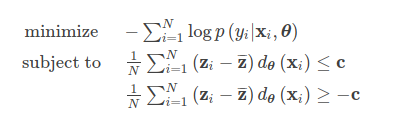

In [ ]:
from sklego.linear_model import DemographicParityClassifier
from sklego.metrics import p_percent_score



demo_parity = DemographicParityClassifier(sensitive_cols=["race_African-American","race_Caucasian","race_Hispanic","race_Other"], covariance_threshold=0.5)
demo_parity.fit(X_train, y_train)

In [ ]:
demo_parity.predict(X_test)

In [ ]:
# confusion matrices for demo parity classifier
SetupMatrix(demo_parity,0)

In [ ]:
print("Demographic Parity Classifier Accuracy: " + str(demo_parity.score(X_test,y_test)))
print("Regular Logistic Regression Accuracy: " + str(clf.score(X_test,y_test)))

In [ ]:
print("Demographic Parity Classifier")
print("P% score for African-American feature: " + str(p_percent_score(sensitive_column="race_African-American")(demo_parity, X)))
print("P% score for Caucasian feature: " + str(p_percent_score(sensitive_column="race_Caucasian")(demo_parity, X)))
print("P% score for Hispanic feature: " + str(p_percent_score(sensitive_column="race_Hispanic")(demo_parity, X)))
print("P% score for Other Race feature: " + str(p_percent_score(sensitive_column="race_Other")(demo_parity, X)))

In [ ]:
print("Regular Logistic Regression")
print("P% score for African-American feature: " + str(p_percent_score(sensitive_column="race_African-American")(clf, X)))
print("P% score for Caucasian feature: " + str(p_percent_score(sensitive_column="race_Caucasian")(clf, X)))
print("P% score for Hispanic feature: " + str(p_percent_score(sensitive_column="race_Hispanic")(clf, X)))
print("P% score for Other Race feature: " + str(p_percent_score(sensitive_column="race_Other")(clf, X)))

### As we can see there is a slight decrease in accuracy but a significant improvement in all of the p% scores except for te caucasian.

### Equal Opportunity Classifier optimizes the following function:

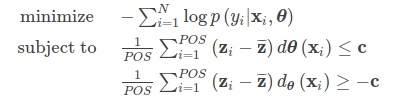

In [ ]:
from sklego.linear_model import EqualOpportunityClassifier

equal_opt = EqualOpportunityClassifier(sensitive_cols=["race_African-American","race_Caucasian","race_Hispanic","race_Other"], covariance_threshold=0.5,positive_target=True)
equal_opt.fit(X_train, y_train)

In [ ]:
equal_opt.predict(X_test)

In [ ]:
# confusion matrices for demo parity classifier
SetupMatrix(clf,0)

In [ ]:
print("Equal Opportunity Classifier accuracy: " + str(equal_opt.score(X_test,y_test)))
print("Regular Logistic Regression Accuracy: " + str(clf.score(X_test,y_test)))

In [ ]:
print("Equal Opportunity Classifier")
print("Equal opportunity score for African-American feature: " + str(equal_opportunity_score(sensitive_column="race_African-American")(equal_opt, X,Y)))
print("Equal opportunity score for Caucasian feature: " + str(equal_opportunity_score(sensitive_column="race_Caucasian")(equal_opt, X,Y)))
print("Equal opportunity score for Hispanic feature: " + str(equal_opportunity_score(sensitive_column="race_Hispanic")(equal_opt, X,Y)))
print("Equal opportunity score for Other Race feature: " + str(equal_opportunity_score(sensitive_column="race_Other")(equal_opt, X,Y)))

In [ ]:
print("Regular Logistic Regression")
print("Equal opportunity score for African-American feature: " + str(equal_opportunity_score(sensitive_column="race_African-American")(clf, X,Y)))
print("Equal opportunity score for Caucasian feature: " + str(equal_opportunity_score(sensitive_column="race_Caucasian")(clf, X,Y)))
print("Equal opportunity score for Hispanic feature: " + str(equal_opportunity_score(sensitive_column="race_Hispanic")(clf, X,Y)))
print("Equal opportunity score for Other Race feature: " + str(equal_opportunity_score(sensitive_column="race_Other")(clf, X,Y)))

### Again using this classifier we get a slight hit on accuracy but we get improved equal opportunity score for every race except the caucasian.